# Multi-Agent Data Analysis Tool

In [1]:
# Install the required python dependencies
%pip install -q pandas matplotlib httpx openpyxl pypdf python-docx

Note: you may need to restart the kernel to use updated packages.


### Imports

In [2]:
# Core Python
import os
import json
import re

# Data handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# LLM HTTP calls (Ollama / later OpenAI)
import httpx

# Document handling
from pypdf import PdfReader
from docx import Document

from IPython.display import Markdown, display
from PIL import Image

### LLM Setup

In [3]:
from typing import List, Dict

class LLMClient:
    def chat(self, messages: List[Dict[str, str]], temperature: float = 0.2) -> str:
        raise NotImplementedError

class OllamaClient(LLMClient):
    def __init__(self, model="llama3.1:8b", base_url="http://localhost:11434"):
        self.model = model
        self.base_url = base_url.rstrip("/")

    def chat(self, messages, temperature=0.2):
        prompt = "\n".join([f"{m['role'].upper()}: {m['content']}" for m in messages])
        payload = {
            "model": self.model,
            "prompt": prompt,
            "options": {"temperature": temperature},
            "stream": False
        }
        r = httpx.post(f"{self.base_url}/api/generate", json=payload, timeout=120)
        r.raise_for_status()
        return r.json()["response"]

llm = OllamaClient(model="llama3.1:8b")

### Folder Index 

In [4]:
def index_folder(data_dir="data", max_preview_cols=30):
    """
    Scans a folder and returns a catalog list of dicts.
    - For CSV/XLSX: reads only headers + small sample to infer columns/dtypes quickly.
    - For PDF/DOCX: does NOT extract full text (keeps it fast); just records type/size.
    """
    catalog = []

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Folder not found: {data_dir}")

    for name in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, name)
        if not os.path.isfile(path):
            continue
        if name.startswith("."):
            continue
        
        ext = os.path.splitext(name.lower())[1]
        item = {
            "name": name,
            "path": path,
            "ext": ext,
            "type": "unknown",   # dataset/document
            "size_kb": round(os.path.getsize(path) / 1024, 1),
            "columns": None,
            "n_cols": None,
            "dtypes": None,
            "notes": ""
        }

        try:
            if ext == ".csv":
                item["type"] = "dataset"
                # fast read: only a few rows
                sample = pd.read_csv(path, nrows=50)
                cols = list(sample.columns)[:max_preview_cols]
                item["columns"] = cols
                item["n_cols"] = len(cols)
                item["dtypes"] = {c: str(sample[c].dtype) for c in cols}

            elif ext in [".xlsx", ".xls"]:
                item["type"] = "dataset"
                sample = pd.read_excel(path, nrows=50)
                cols = list(sample.columns)[:max_preview_cols]
                item["columns"] = cols
                item["n_cols"] = len(cols)
                item["dtypes"] = {c: str(sample[c].dtype) for c in cols}

            elif ext == ".pdf":
                item["type"] = "document"
                item["notes"] = "PDF (text extraction happens during load step)"

            elif ext == ".docx":
                item["type"] = "document"
                item["notes"] = "DOCX (text extraction happens during load step)"

            else:
                item["notes"] = "Unsupported/ignored file type"

        except Exception as e:
            item["notes"] = f"Index error: {e}"

        catalog.append(item)

    return catalog

### Data Source Selector Agent

In [5]:
def data_source_selector(llm, question: str, catalog: list) -> dict:
    # keep the catalog summary small for the LLM
    catalog_summary = []
    for c in catalog:
        catalog_summary.append({
            "name": c.get("name"),
            "path": c.get("path"),
            "type": c.get("type"),
            "ext": c.get("ext"),
            "columns": c.get("columns", [])[:25] if c.get("columns") else []
        })

    prompt = f"""
You are a data source selector for a senior data analyst system.

Goal:
Choose the best ONE file from the catalog to answer the user's question.

Rules:
- Prefer type="dataset" for KPI/top/groupby/compare/metrics questions.
- Prefer type="document" for summarize/explain/report/paper questions.
- If unsure, choose the dataset that has columns most related to the question.

Return ONLY JSON with:
- mode: "dataset" or "document"
- selected_paths: [one path]
- reason: short explanation

Catalog:
{catalog_summary}

User question:
{question}

Return JSON ONLY.
"""
    raw = llm.chat([{"role":"user","content":prompt}], temperature=0.0)

    try:
        out = json.loads(raw)
    except Exception:
        m = re.search(r"\{.*\}", raw, re.S)
        out = json.loads(m.group(0)) if m else {}

    # minimal validation + fallback
    paths = out.get("selected_paths") or []
    if not paths:
        return {"mode":"unknown","selected_paths":[],"reason":"LLM selector failed to choose. Use v1 fallback."}
    return out

### File Loader

In [6]:
def load_file(file_path):
    ext = os.path.splitext(file_path.lower())[1]

    payload = {
        "source_path": file_path,
        "type": None,        
        "df": None,          
        "text": None,        
        "tables": [],        
        "meta": {"ext": ext}
    }

    try:
        if ext == ".csv":
            payload["type"] = "dataset"
            payload["df"] = pd.read_csv(file_path)

        elif ext in [".xlsx", ".xls"]:
            payload["type"] = "dataset"
            payload["df"] = pd.read_excel(file_path)

        elif ext == ".pdf":
            payload["type"] = "document"
            reader = PdfReader(file_path)
            text = []
            for page in reader.pages:
                text.append(page.extract_text() or "")
            payload["text"] = "\n".join(text)

        elif ext == ".docx":
            payload["type"] = "document"
            doc = Document(file_path)
            payload["text"] = "\n".join([p.text for p in doc.paragraphs if p.text.strip()])

        else:
            raise ValueError(f"Unsupported file type: {ext}")

        # Optional: quick status
        if payload["type"] == "dataset":
            payload["meta"]["shape"] = list(payload["df"].shape)
        else:
            payload["meta"]["text_chars"] = len(payload["text"] or "")

        return payload

    except Exception as e:
        payload["meta"]["error"] = str(e)
        return payload
    
def load_selected_sources(selection: dict):
    paths = selection.get("selected_paths") or []
    if not paths:
        return {"error": "No paths selected", "selection": selection}

    payloads = [load_file(p) for p in paths]

    return {
        "mode": selection.get("mode"),
        "reason": selection.get("reason"),
        "payloads": payloads
    }


### Query Interpreter Agent

In [7]:
def query_interpreter(llm, question: str, df) -> dict:
    cols = list(df.columns)

    prompt = f"""
You are the Query Interpreter for a senior data analyst system.

Your job:
Turn the user's question into a JSON plan that we can execute on a pandas DataFrame.

Return ONLY JSON with keys:
- intent: one of ["summary","top_n","groupby","kpi","unknown"]
- groupby: a column name from the dataset OR null
- metric: a column name from the dataset OR null
- agg: one of ["sum","mean","count"] OR null
- n: integer OR null
- chart: one of ["bar","line","none"]
- missing_info: list of strings (empty if nothing missing)

Rules:
- groupby and metric MUST be exact matches from dataset columns (case-sensitive).
- If the user asks for a column that does not exist, pick the closest available alternative and explain in missing_info.
- If "top" is mentioned, set intent="top_n" and n accordingly (default 5 if not stated).
- If the user mentions a chart, set chart accordingly.
- If grouping by a category and metric is numeric, default agg="sum" unless user specifies average or count.
- If user says "average" use agg="mean".
- If user says "count" use agg="count".
- For top_n queries with metric + groupby, agg MUST NOT be null.
- If the user asks "total <metric> by <group>", set intent="groupby" and agg="sum".
- Use intent="summary" ONLY for general dataset overview questions (e.g., "summarize the dataset", "data quality", "missing values").

Dataset columns:
{cols}

User question:
{question}

Return JSON ONLY.
"""

    raw = llm.chat([{"role":"user","content":prompt}], temperature=0.0)

    # safe parse
    try:
        return json.loads(raw)
    except Exception:
        m = re.search(r"\{.*\}", raw, re.S)
        return json.loads(m.group(0)) if m else {"intent":"unknown","missing_info":["json_parse_failed"]}

### Data Analysis Agent

In [8]:
def data_analysis_agent(df, plan: dict, output_dir="outputs") -> dict:
    os.makedirs(output_dir, exist_ok=True)

    intent = plan.get("intent", "unknown")
    groupby = plan.get("groupby")
    metric = plan.get("metric")
    agg = plan.get("agg") or None
    n = plan.get("n")
    chart = (plan.get("chart") or "none").lower().strip()

    # supported charts: bar, line, scatter, pie, donut, area, hist, box, heatmap
    # notes:
    # - heatmap is only supported if plan provides x_col/y_col/value_col under plan["heatmap"]
    # - scatter/area generally expect numeric x; for grouped results we use category index
    # - hist/box are supported for raw metric distributions (ignores groupby if present)

    out = {
        "intent": intent,
        "plan": plan,
        "result_df": None,
        "chart_path": None,
        "meta": {}
    }

    def ensure_numeric(series: pd.Series) -> pd.Series:
        return pd.to_numeric(series, errors="coerce")

    def sanitize_labels(series: pd.Series, missing_label: str = "Unknown") -> list[str]:
        """Return a pure Python list[str] safe for matplotlib categorical axes."""
        if series is None:
            return []
        s = series.copy()
        s = s.where(s.notna(), missing_label)
        return s.astype(str).tolist()

    def safe_filename(s: str) -> str:
        s = str(s)
        keep = []
        for ch in s:
            if ch.isalnum() or ch in ["-", "_", "."]:
                keep.append(ch)
            else:
                keep.append("_")
        return "".join(keep)[:120]

    def maybe_savefig(fig_path: str) -> str:
        plt.tight_layout()
        plt.savefig(fig_path, dpi=150)
        plt.close()
        return fig_path

    # =========================
    # SUMMARY
    # =========================
    if intent == "summary":
        out["meta"]["rows"] = len(df)
        out["meta"]["cols"] = len(df.columns)
        out["meta"]["missing_by_col"] = (
            df.isna().sum().sort_values(ascending=False).head(10).to_dict()
        )
        out["meta"]["dtypes"] = {c: str(t) for c, t in df.dtypes.items()}
        return out

    # =========================
    # KPI (single number, no groupby required)
    # =========================
    if intent == "kpi":
        if metric is None or metric not in df.columns:
            out["meta"]["error"] = f"metric column not found: {metric}"
            return out

        if agg is None:
            agg = "sum"

        tmp = df.copy()
        tmp[metric] = ensure_numeric(tmp[metric])

        if agg == "sum":
            value = tmp[metric].sum()
        elif agg == "mean":
            value = tmp[metric].mean()
        elif agg == "count":
            value = tmp[metric].count()
        else:
            out["meta"]["error"] = f"unsupported agg: {agg}"
            return out

        label = f"{agg}_{metric}"
        out["result_df"] = pd.DataFrame([{label: value}])
        out["meta"]["agg_used"] = agg
        out["meta"]["metric"] = metric

        # KPI chart (bar/line is fine; pie/donut not meaningful)
        if chart in ["bar", "line", "scatter", "area"]:
            fig_path = os.path.join(output_dir, f"chart_kpi_{safe_filename(metric)}_{safe_filename(chart)}.png")

            x_labels = [str(metric)]
            y_vals = [float(value) if pd.notna(value) else 0.0]

            plt.figure(figsize=(6, 4))
            if chart == "line":
                plt.plot(x_labels, y_vals, marker="o")
            elif chart == "scatter":
                plt.scatter([0], y_vals)
                plt.xticks([0], x_labels, rotation=0)
            elif chart == "area":
                plt.fill_between([0], y_vals, [0])
                plt.xticks([0], x_labels, rotation=0)
            else:
                plt.bar(x_labels, y_vals)

            plt.title(f"KPI: {label}")
            out["chart_path"] = maybe_savefig(fig_path)

        elif chart in ["hist", "box"]:
            # treat as distribution chart even in KPI intent
            fig_path = os.path.join(output_dir, f"chart_dist_{safe_filename(metric)}_{safe_filename(chart)}.png")
            vals = tmp[metric].dropna().astype(float)

            plt.figure(figsize=(8, 4))
            if chart == "hist":
                plt.hist(vals, bins=20)
                plt.title(f"Distribution (hist): {metric}")
                plt.xlabel(metric)
                plt.ylabel("Count")
            else:
                plt.boxplot(vals, vert=False)
                plt.title(f"Distribution (box): {metric}")
                plt.xlabel(metric)

            out["chart_path"] = maybe_savefig(fig_path)

        return out

    # =========================
    # GROUPBY / TOP_N (requires groupby + metric)
    # =========================
    if intent in ["top_n", "groupby"]:
        # Basic validation
        if groupby is None or groupby not in df.columns:
            out["meta"]["error"] = f"groupby column not found: {groupby}"
            return out

        if metric is None or metric not in df.columns:
            out["meta"]["error"] = f"metric column not found: {metric}"
            return out

        if agg is None:
            agg = "sum"

        tmp = df.copy()

        # ✅ Clean group labels BEFORE grouping so NaNs don't propagate
        tmp[groupby] = tmp[groupby].where(tmp[groupby].notna(), "Unknown").astype(str)

        # ✅ Ensure metric is numeric
        tmp[metric] = ensure_numeric(tmp[metric])

        g = tmp.groupby(groupby, dropna=False)[metric]

        if agg == "sum":
            res = g.sum()
        elif agg == "mean":
            res = g.mean()
        elif agg == "count":
            res = g.count()
        else:
            out["meta"]["error"] = f"unsupported agg: {agg}"
            return out

        sort_col = f"{agg}_{metric}"
        res_df = res.reset_index().rename(columns={metric: sort_col})
        res_df = res_df.sort_values(sort_col, ascending=False)

        if intent == "top_n":
            top_n = int(n) if n else 5
            available = len(res_df)
            if top_n > available:
                out["meta"]["note"] = (
                    f"Requested top {top_n}, but only {available} groups exist. Returning all."
                )
            res_df = res_df.head(top_n)
            out["meta"]["top_n"] = min(top_n, available)

        out["result_df"] = res_df
        out["meta"]["agg_used"] = agg
        out["meta"]["groupby"] = groupby
        out["meta"]["metric"] = metric

        # =========================
        # Chart generation (more types)
        # =========================
        if chart != "none":
            fig_path = os.path.join(
                output_dir,
                f"chart_{safe_filename(intent)}_{safe_filename(groupby)}_{safe_filename(metric)}_{safe_filename(chart)}.png"
            )

            # Safe labels + values
            x_labels = sanitize_labels(res_df[groupby], missing_label="Unknown")
            y_vals = (
                pd.to_numeric(res_df[sort_col], errors="coerce")
                .fillna(0)
                .astype(float)
                .tolist()
            )

            # numeric x positions (useful for scatter/area/barh)
            x_pos = list(range(len(x_labels)))

            plt.figure(figsize=(10, 5))

            if chart == "bar":
                plt.bar(x_labels, y_vals)
                plt.xticks(rotation=45, ha="right")

            elif chart == "barh":
                plt.barh(x_labels, y_vals)
                plt.yticks(rotation=0)
                plt.gca().invert_yaxis()  # biggest at top

            elif chart == "line":
                plt.plot(x_labels, y_vals, marker="o")
                plt.xticks(rotation=45, ha="right")

            elif chart == "area":
                plt.fill_between(x_pos, y_vals, [0] * len(y_vals))
                plt.xticks(x_pos, x_labels, rotation=45, ha="right")

            elif chart == "scatter":
                # scatter needs numeric x; use category indices and label them
                plt.scatter(x_pos, y_vals)
                plt.xticks(x_pos, x_labels, rotation=45, ha="right")

            elif chart in ["pie", "donut"]:
                # pie/donut: avoid clutter if too many slices
                # (top_n already helps; still safe-guard)
                labels = x_labels
                values = y_vals

                # Remove zero slices to keep pie sane
                filtered = [(l, v) for l, v in zip(labels, values) if v > 0]
                if not filtered:
                    out["meta"]["error"] = "pie/donut chart has no positive values to display"
                    plt.close()
                    return out

                labels, values = zip(*filtered)
                plt.pie(values, labels=labels, autopct="%1.1f%%")

                if chart == "donut":
                    # add donut hole
                    centre_circle = plt.Circle((0, 0), 0.60, fc="white")
                    plt.gca().add_artist(centre_circle)

            elif chart == "hist":
                # distribution of aggregated y values (not raw)
                plt.hist(y_vals, bins=min(20, max(5, len(y_vals))))
                plt.title(f"Histogram of {sort_col}")
                plt.xlabel(sort_col)
                plt.ylabel("Count")

            elif chart == "box":
                # box plot of aggregated y values (not raw)
                plt.boxplot(y_vals, vert=False)
                plt.title(f"Box plot of {sort_col}")
                plt.xlabel(sort_col)

            else:
                out["meta"]["error"] = f"unsupported chart type: {chart}"
                plt.close()
                return out

            # Title/labels for non-pie charts
            if chart not in ["pie", "donut", "hist", "box"]:
                plt.title(f"{intent}: {groupby} vs {sort_col} ({chart})")
                if chart not in ["barh"]:
                    plt.ylabel(sort_col)
                else:
                    plt.xlabel(sort_col)

            out["chart_path"] = maybe_savefig(fig_path)

        return out

    # =========================
    # UNKNOWN INTENT
    # =========================
    out["meta"]["error"] = f"unsupported intent: {intent}"
    return out

### Insight Validator Agent

In [9]:
def insight_validator_agent(question: str, plan: dict, analysis_out: dict) -> dict:
    issues = []
    notes = []

    intent = plan.get("intent", "unknown")
    requested_n = plan.get("n")
    groupby = plan.get("groupby")
    metric = plan.get("metric")
    agg = plan.get("agg")
    chart = plan.get("chart")

    result_df = analysis_out.get("result_df")
    meta = analysis_out.get("meta", {})
    chart_path = analysis_out.get("chart_path")

    # 1) Basic existence checks
    if intent in ["top_n", "groupby", "kpi"]:
        if result_df is None or len(result_df) == 0:
            issues.append("No results were produced for the requested analysis.")
            return {"status": "issues", "issues": issues, "notes": notes}

    # 2) Column sanity checks
    if groupby and result_df is not None and groupby not in result_df.columns:
        # In our executor, groupby becomes a column in result_df
        # If it's missing, something is off.
        issues.append(f"Expected groupby column '{groupby}' missing from results.")

    # 3) Aggregation sanity checks (common LLM failure)
    if intent in ["top_n", "groupby", "kpi"]:
        if agg is None:
            issues.append("Aggregation (agg) is missing for a grouped metric query.")
        if metric is None:
            issues.append("Metric column is missing in the plan.")
        if groupby is None:
            issues.append("Groupby column is missing in the plan.")

    # 4) Top-N mismatch check (your exact scenario)
    if intent == "top_n" and requested_n:
        actual_n = len(result_df)
        if actual_n < int(requested_n):
            notes.append(
                f"Requested top {requested_n}, but only {actual_n} unique '{groupby}' values exist in the data. Returning all available groups."
            )

    # 5) Chart expectations
    if chart in ["bar", "line"]:
        if not chart_path:
            issues.append(f"Chart '{chart}' was requested but no chart was generated.")
        else:
            notes.append(f"A {chart} chart was generated and saved to: {chart_path}")

    # 6) Result reasonableness (basic)
    # if metric is numeric aggregation, values should not all be NaN
    if result_df is not None:
        numeric_cols = [c for c in result_df.columns if c.startswith(("sum_", "mean_", "count_"))]
        for c in numeric_cols:
            if result_df[c].isna().all():
                issues.append(f"All values in result column '{c}' are NaN. Metric might not be numeric or data is missing.")

    status = "ok" if len(issues) == 0 else "issues"
    return {"status": status, "issues": issues, "notes": notes}

### Report Generator Agent

In [10]:
def report_generator_agent(question: str, selection: dict, plan: dict, analysis_out: dict, validation: dict) -> str:
    mode = selection.get("mode")
    selected_paths = selection.get("selected_paths", [])
    reason = selection.get("reason", "")

    notes = validation.get("notes", [])
    issues = validation.get("issues", [])

    # =========================
    # DOCUMENT MODE
    # =========================
    if mode == "document":
        doc_answer = analysis_out.get("doc_answer") or analysis_out.get("answer") or ""
        path = selected_paths[0] if selected_paths else "Unknown document"

        lines = []
        lines.append("# Senior Document Analyst Report\n")

        lines.append("## Executive Summary")
        lines.append(f"- **Question:** {question}")
        lines.append(f"- **Mode:** document")
        lines.append(f"- **Document used:** `{path}`")
        if reason:
            lines.append(f"- **Why this document:** {reason}")
        lines.append("")

        lines.append("## Answer / Summary")
        lines.append(doc_answer if doc_answer else "No document answer was produced.")
        lines.append("")

        lines.append("## Validation & Notes")
        if notes:
            for n in notes:
                lines.append(f"- {n}")
        else:
            lines.append("- No additional notes.")
        if issues:
            lines.append("\n**Issues detected:**")
            for it in issues:
                lines.append(f"- {it}")
        lines.append("")

        lines.append("## Next Actions")
        lines.append("- If you want deeper accuracy, extract only the **Abstract** section (instead of first X characters) and summarize that.")
        lines.append("- For long PDFs, add chunking + retrieval so answers cite the most relevant section.")
        lines.append("")

        return "\n".join(lines)

    # =========================
    # DATASET MODE (default)
    # =========================
    result_df = analysis_out.get("result_df")
    chart_path = analysis_out.get("chart_path")

    lines = []
    lines.append("# Senior Data Analyst Report\n")

    # Executive summary
    lines.append("## Executive Summary")
    lines.append(f"- **Question:** {question}")
    lines.append(f"- **Data mode:** {mode}")
    if selected_paths:
        lines.append(f"- **Data used:** `{selected_paths[0]}`")
    if reason:
        lines.append(f"- **Why this data:** {reason}")
    lines.append("")

    # Analysis plan
    lines.append("## Analysis Plan (Interpreted)")
    lines.append(f"- **Intent:** {plan.get('intent')}")
    lines.append(f"- **Group by:** {plan.get('groupby')}")
    lines.append(f"- **Metric:** {plan.get('metric')}")
    lines.append(f"- **Aggregation:** {plan.get('agg')}")
    lines.append(f"- **Top N:** {plan.get('n')}")
    lines.append(f"- **Chart requested:** {plan.get('chart')}")
    lines.append("")

    # Key results
    lines.append("## Key Results")
    if result_df is not None and len(result_df) > 0:
        lines.append("Top results (preview):")
        lines.append(result_df.to_string(index=False))
    else:
        lines.append("No result table was produced.")
    lines.append("")

    # Validation notes
    lines.append("## Validation & Notes")
    if notes:
        for n in notes:
            lines.append(f"- {n}")
    else:
        lines.append("- No additional notes.")
    if issues:
        lines.append("\n**Issues detected:**")
        for it in issues:
            lines.append(f"- {it}")
    lines.append("")

    # Visualization
    lines.append("## Visualizations")
    if chart_path:
        lines.append(f"- Chart saved at: `{chart_path}`")
    else:
        lines.append("- No chart generated.")
    lines.append("")

    # Recommendations
    lines.append("## Recommendations / Next Actions")
    lines.append("- If needed, break down metrics further by **Region**, **Segment**, or **Sub-Category** to identify opportunities.")
    lines.append("- Consider trend analysis over **Order Date** to see seasonality (requires date aggregation).")
    lines.append("")

    return "\n".join(lines)

### Orchestrator Agent

In [11]:
def run_data_analyst(question: str, data_dir="data", use_llm_selector=True) -> dict:
    # 1) Index folder
    catalog = index_folder(data_dir)

    # 2) Select source (LLM selector)
    selection = data_source_selector(llm, question, catalog)

    # 3) Load selected source(s)
    loaded = load_selected_sources(selection)

    if not loaded.get("payloads"):
        return {
            "question": question,
            "catalog": catalog,
            "selection": selection,
            "loaded": loaded,
            "error": "No files loaded."
        }

    payload0 = loaded["payloads"][0]

    # ============================================================
    # DATASET MODE
    # ============================================================
    if payload0["type"] == "dataset":

        df = payload0["df"]

        # 4) Interpret
        plan = query_interpreter(llm, question, df)

        # enforce safe aggregation default
        if plan.get("intent") in ["top_n", "groupby", "kpi"] and plan.get("agg") is None:
            plan["agg"] = "sum"

        # 5) Analyze
        analysis_out = data_analysis_agent(df, plan, output_dir="outputs")

        # 6) Validate
        validation = insight_validator_agent(question, plan, analysis_out)

        # 7) Report
        report = report_generator_agent(question, selection, plan, analysis_out, validation)

        return {
            "question": question,
            "catalog": catalog,
            "selection": selection,
            "loaded": loaded,
            "plan": plan,
            "analysis_out": analysis_out,
            "validation": validation,
            "report": report
        }

    # ============================================================
    # DOCUMENT MODE
    # ============================================================
    elif payload0["type"] == "document":

        text = payload0.get("text", "")

        if not text:
            return {
                "question": question,
                "catalog": catalog,
                "selection": selection,
                "loaded": loaded,
                "error": "Document loaded but no text extracted."
            }

        # 4) Ask LLM to answer based on document text
        doc_prompt = f"""
You are a senior document analyst.

Answer the user's question using ONLY the content below.

User question:
{question}

Document content:
{text[:4000]}   # truncate for safety

Answer clearly and professionally.
"""

        doc_answer = llm.chat([{"role": "user", "content": doc_prompt}], temperature=0.0)

        analysis_out = {
            "doc_answer": doc_answer
        }

        validation = {
            "status": "ok",
            "issues": [],
            "notes": ["Answer generated from document text."]
        }

        report = report_generator_agent(question, selection, {}, analysis_out, validation)

        return {
            "question": question,
            "catalog": catalog,
            "selection": selection,
            "loaded": loaded,
            "analysis_out": analysis_out,
            "validation": validation,
            "report": report
        }

    else:
        return {
            "question": question,
            "catalog": catalog,
            "selection": selection,
            "loaded": loaded,
            "error": "Unknown payload type."
        }

# Senior Data Analyst Report

## Executive Summary
- **Question:** What is the total NA sales by genre and a pie chart?
- **Data mode:** dataset
- **Data used:** `Data\Video-Game-Sales.csv`
- **Why this data:** Dataset preferred for KPI/top/groupby/compare/metrics questions

## Analysis Plan (Interpreted)
- **Intent:** groupby
- **Group by:** Genre
- **Metric:** NA_Sales
- **Aggregation:** sum
- **Top N:** None
- **Chart requested:** pie

## Key Results
Top results (preview):
       Genre  sum_NA_Sales
      Action        879.01
      Sports        684.43
     Shooter        592.24
    Platform        445.50
        Misc        407.27
      Racing        359.35
Role-Playing        330.81
    Fighting        223.36
  Simulation        182.19
      Puzzle        122.87
   Adventure        105.26
    Strategy         68.55
     Unknown          1.78

## Validation & Notes
- No additional notes.

## Visualizations
- Chart saved at: `outputs\chart_groupby_Genre_NA_Sales_pie.png`

## Recommendations / Next Actions
- If needed, break down metrics further by **Region**, **Segment**, or **Sub-Category** to identify opportunities.
- Consider trend analysis over **Order Date** to see seasonality (requires date aggregation).


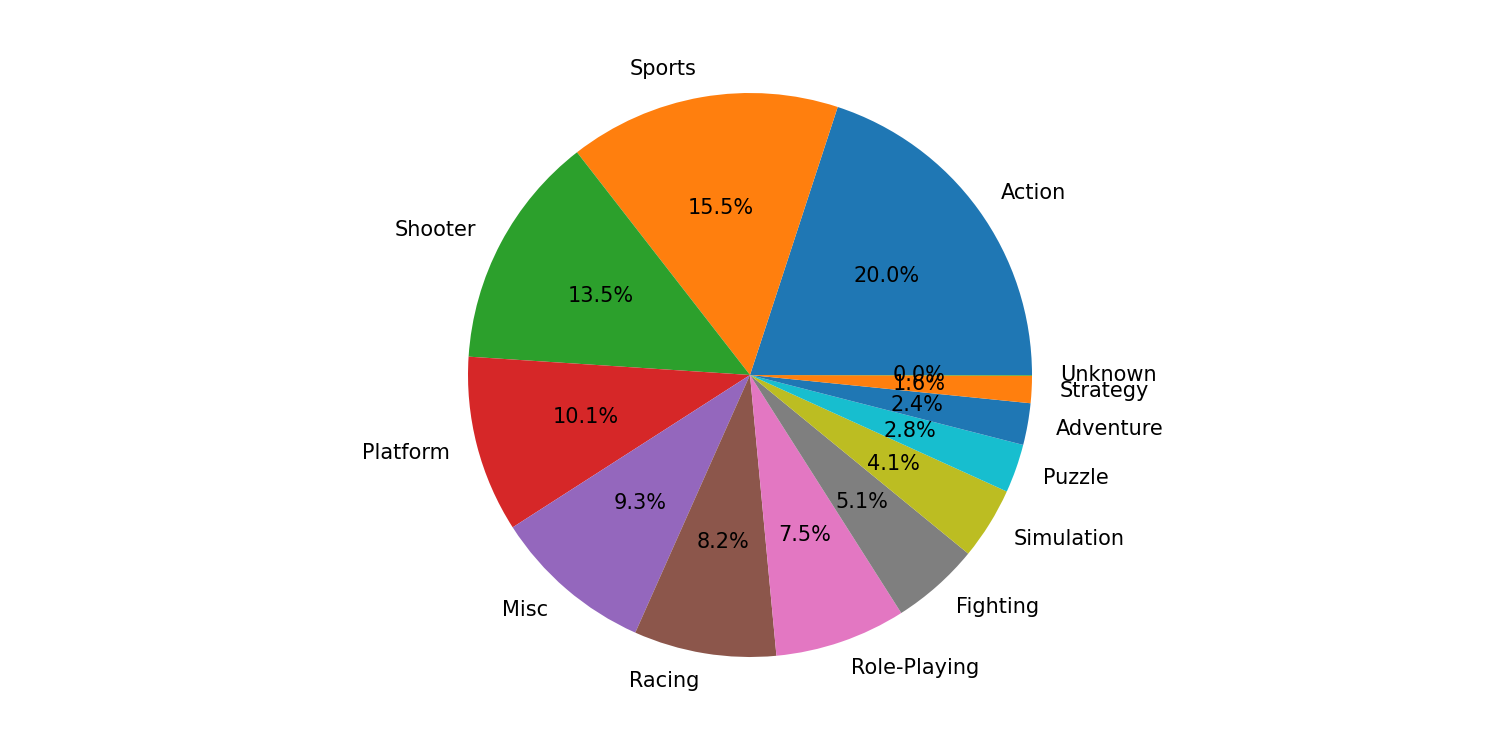

In [12]:
out = run_data_analyst("What is the total NA sales by genre and a pie chart?", data_dir="Data")
display(Markdown(out["report"]))

chart_path = out.get("analysis_out", {}).get("chart_path")
if chart_path:
    display(Image.open(chart_path))
else:
    print("No chart to display (chart_path is None).")